# Predict Disneyland Reviews from Review Text

## Package Installation + Setup
---

Because multiple team members used google drive, please check the drive path in each notebook. They might be slightly different!

In [1]:
# Install PySpark pacakges and set environment variables to use Spark on Colab
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

!pip install pysparkling

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
# Google Drive Authentication
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# PROJECT PATH
cur_path = "/content/drive/MyDrive/Colab Notebooks/BigDataScaling/Project/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/data_scaling/Week8_TreeMethods


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
import pyspark.sql.functions as f
from pysparkling import *  
from nltk.corpus import stopwords 
from pyspark.sql.functions import col

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier

import seaborn as sns
import numpy as np

In [4]:
# create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tree').getOrCreate()

# Introduce three tree methods:
[Single decision tree] (https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

[Random forest](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier)

[Gradient Boosted Tree](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier)

## Load + Clean Data
---

Load the Disneyland Reviews CSV and clean year/month and branch columns

In [5]:
# Load data
data = spark.read.csv(cur_path + 'DisneylandReviews.csv',inferSchema=True,header=True)

In [6]:
data.printSchema()

root
 |-- Review_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Year_Month: string (nullable = true)
 |-- Reviewer_Location: string (nullable = true)
 |-- Review_Text: string (nullable = true)
 |-- Branch: string (nullable = true)



## Tokenize Review Text
---

To predict a review's rating from their text, we have are going tokenize the reviews and remove stop words. We can then creat a TFIDF with a min-frequecy of 6 to remove any sparse/rarely used words.

In [9]:
# Tokenize review text
tokenizer = RegexTokenizer(inputCol='Review_Text', outputCol = 'tokenized_words', pattern="\\W+", minTokenLength = 3)
tokenized_output = tokenizer.transform(data)

# Remove stop words
remover = StopWordsRemover(inputCol='tokenized_words', outputCol = 'word_tokens')
tokenized_output = remover.transform(tokenized_output)

# Quick preview
tokenized_output.show(5)

+---------+------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|     tokenized_words|         word_tokens|
+---------+------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+
|670772142|     4|    2019-4|           Australia|If you've ever be...|Disneyland_HongKong|[you, ever, been,...|[ever, disneyland...|
|670682799|     4|    2019-5|         Philippines|Its been a while ...|Disneyland_HongKong|[its, been, while...|[since, last, tim...|
|670623270|     4|    2019-4|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|[thanks, god, was...|[thanks, god, was...|
|670607911|     4|    2019-4|           Australia|HK Disneyland is ...|Disneyland_HongKong|[disneyland, grea...|[disneyland, grea...|
|670607296|     4|    2019-4|      United Kingdom|the location

In [10]:
# Only showing target (rating) and tokenized words
out = tokenized_output.select(["Rating", "word_tokens"])
out.show(5)

+------+--------------------+
|Rating|         word_tokens|
+------+--------------------+
|     4|[ever, disneyland...|
|     4|[since, last, tim...|
|     4|[thanks, god, was...|
|     4|[disneyland, grea...|
|     4|[location, city, ...|
+------+--------------------+
only showing top 5 rows



## Create Dataset for Model Training


In [ ]:
# Split dataset
(train_set, test_set) = out.randomSplit([0.7, 0.3], seed = 100)

In [ ]:
# TFIDF Hashing + Pipeline
hashtf = HashingTF(numFeatures=2**16, inputCol="word_tokens", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

pipeline = Pipeline(stages=[hashtf, idf])

In [13]:
# Create a test/train dataframe that includes our term frequency
# We'll use this in our modeling below
pipelineFit = pipeline.fit(train_set.withColumnRenamed("Rating","label"))
train_df = pipelineFit.transform(train_set.withColumnRenamed("Rating","label"))
test_df = pipelineFit.transform(test_set.withColumnRenamed("Rating","label"))
train_df.show(5)

+-----+--------------------+--------------------+--------------------+
|label|         word_tokens|                  tf|            features|
+-----+--------------------+--------------------+--------------------+
|    1|[2nd, time, park,...|(65536,[523,1097,...|(65536,[523,1097,...|
|    1|[38c, weather, pr...|(65536,[518,548,6...|(65536,[518,548,6...|
|    1|[3rd, disney, par...|(65536,[1581,1753...|(65536,[1581,1753...|
|    1|[499, hkd, per, o...|(65536,[329,466,1...|(65536,[329,466,1...|
|    1|[abomination, hon...|(65536,[714,2860,...|(65536,[714,2860,...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



## Logistic Regression

### Hyperparameter Selection (k-fold CV)

In [ ]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.025, 0.05, 0.075]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0, 0.005, 0.01, 0.015]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [200]) #Number of iterations
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=acc_evaluator, \
                    numFolds=5)

cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)

In [ ]:
cvModel.avgMetrics

In [ ]:
bestModel = cvModel.bestModel
print(bestModel._java_obj.getRegParam())
print(bestModel._java_obj.getMaxIter())
print(bestModel._java_obj.getElasticNetParam())
print(cvModel.avgMetrics)

### Train + Evaluate using Best Hyperparameters

In [4]:
# Initialize model
lr = LogisticRegression(maxIter=200, regParam=0.05, elasticNetParam=0.015)

# Fit model + predict test set
lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)

In [16]:
# Preview -- Where we predicted 5* reviews
predictions.filter(predictions['prediction'] == 5) \
    .select("word_tokens","label","probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 5, truncate = 30)

+------------------------------+-----+------------------------------+----------+
|                   word_tokens|label|                   probability|prediction|
+------------------------------+-----+------------------------------+----------+
|[hope, review, prepare, fir...|    5|[0.0,0.4114359065588254,0.0...|       5.0|
|[absolutely, love, disneyla...|    5|[0.0,0.40812554331492346,0....|       5.0|
|[disneyland, paris, utterly...|    1|[0.0,0.33028070711412133,0....|       5.0|
|[horrible, expersive, food,...|    2|[0.0,0.327599896358041,0.05...|       5.0|
|[pros, hotel, rooms, wonder...|    1|[0.0,0.32207956214420325,0....|       5.0|
+------------------------------+-----+------------------------------+----------+
only showing top 5 rows



In [17]:
# Accuracy (Logistic Regression)
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc_evaluator.evaluate(predictions)

0.6037275872916011

In [43]:
# Classification Report (Logistic Regression)
preds_and_labels = predictions.select(["prediction","label"])
y_true = preds_and_labels.select(['label']).collect()
y_pred = preds_and_labels.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.27      0.35       449
           2       0.41      0.17      0.24       647
           3       0.37      0.23      0.29      1531
           4       0.41      0.28      0.33      3199
           5       0.69      0.90      0.78      6890

    accuracy                           0.60     12716
   macro avg       0.47      0.37      0.40     12716
weighted avg       0.56      0.60      0.56     12716



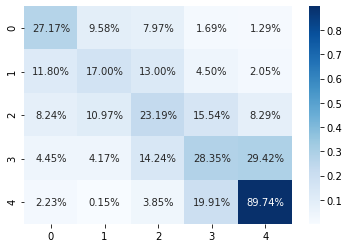

In [54]:
# Confusion Matrix (Percentages)
cf_matrix = confusion_matrix(y_true,y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=1), annot=True, fmt='.2%', cmap='Blues');

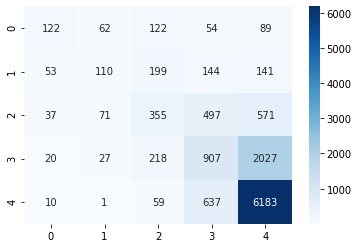

In [65]:
# Confusion Matrix (Prediction Counts)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g');

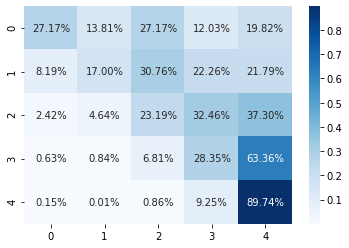

In [67]:
s1 = 122+62+122+54+89
s2 = 53+110+199+144+141
s3 = 37+71+355+497+571
s4 = 20+27+218+907+2027
s5 = 10+1+59+637+6183
A = [[122/s1,62/s1,122/s1,54/s1,89/s1], 
     [53/s2,110/s2,199/s2,144/s2,141/s2,],
     [37/s3,71/s3,355/s3,497/s3,571/s3],
     [20/s4,27/s4,218/s4,907/s4,2027/s4],
     [10/s5,1/s5,59/s5,637/s5,6183/s5]]

sns.heatmap(A, annot=True, cmap='Blues', fmt='.2%')

## Tree Classifiers

In [21]:
rfc = RandomForestClassifier(labelCol='label',featuresCol='features')
rfc_model = rfc.fit(train_df)
rfc_predictions = rfc_model.transform(test_df)

In [22]:
dtc = DecisionTreeClassifier(labelCol='label',featuresCol='features')
dtc_model = dtc.fit(train_df)
dtc_predictions = dtc_model.transform(test_df)

In [23]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)

print("Here are the results!")
print('-'*80)
print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*80)
print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*80)

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had an accuracy of: 55.33%
--------------------------------------------------------------------------------
A random forest ensemble had an accuracy of: 54.18%
--------------------------------------------------------------------------------


## Naive Bayes Classifer

In [24]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1)
model = nb.fit(train_df)

predictions_nb = model.transform(test_df)
predictions_nb.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|         word_tokens|                  tf|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    1|[3rd, visit, disn...|(65536,[3639,3920...|(65536,[3639,3920...|[-1059.6133814658...|[4.41503290323994...|       3.0|
|    1|[actual, experien...|(65536,[377,465,2...|(65536,[377,465,2...|[-3400.3366952778...|[3.1607935981075E...|       1.0|
|    1|[advice, others, ...|(65536,[2692,3639...|(65536,[2692,3639...|[-705.35005398700...|[2.85092472811308...|       2.0|
|    1|[although, great,...|(65536,[338,2026,...|(65536,[338,2026,...|[-2889.5854508669...|[0.00900902763801...|       2.0|
|    1|[although, spend,...|(65536,[1198,1391...|(65536,[1198,1391...|[-465.42712476674...|[6.73865593076808...|       3.0|
|    1|[

In [25]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions_nb)

0.12284820279120354